In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, Ridge, LassoCV
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, train_test_split, RepeatedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

### The Lasso and Ridge Regression

Multiple linear regressions are an extremely versatile tool in the world of machine learning, it represents one of the more elegant ways of both predicting data as well as providing insight for statistical inference. 

As the world of data science grows the quality and quantity of data has grown as well. One pitfall of most machine learning algorithms is that they can easily be overfit given the vastness of high dimensional datasets.

In turn methods have been developed that aim to control this symptom, many exist but the lasso and ridge are amongst some of the more popular due to their effectiveness and simplicity.


___
The main idea behind these methods is to control overfitting by means of a cost function. The principle is simple, the more features we include in the model the higher the cost, so the model we attempt to build should offer a tradeoff of overall accuracy while optimizing for a reduced cost. In simpler terms the model will be punished for using more dimensions in the final result.

Heres how it works.

The equation for the Lasso regression introduces a cost function in the form of the L1 regularization in addition to the traditional regression equation...

$$\lambda \sum\limits_{j=0}^{p}|{\beta_j}|$$

So overall the entire function we wish to optimize is...

$$min(\sum\limits_{i=0}^{N}(y_i - \sum\limits_{j=0}^{p}x_{ij}\beta_j)^2+\lambda \sum\limits_{j=0}^{p}|{\beta_j}|)$$


In the equation above we see that lambda is a hyperparameter that must be selected prior to fitting the regression, the aim here will be to design some process that helps to identify the optimal lambda. (Note: The optimization algorithm used for LASSO is coordinate descent by default in sklearns package, typically one would use gradient descent however notice that the derivative for the absolute value of $\beta_j$ is not defined at 0 so another method must be used.
___

The Ridge regression works on a similar principle with L2 regularization.

$$\lambda\sum\limits_{j=0}^{p}\beta_j^2$$

$$min(\sum\limits_{i=0}^{N}(y_i - \sum\limits_{j=0}^{p}x_{ij}\beta_j)^2+\lambda\sum\limits_{j=0}^{p}\beta_j^2)$$

In this instance we take the square of each coefficient as opposed to the absolute value.

In [2]:
with open('C:\\Users\\sjmif\\Documents\\economic data\\DATA.csv') as f:
    data=pd.read_csv(f)

The dataset loaded above is a selection of macroeconomic indicators for the US economy, there are numerous features some of which will quite clearly be highly correlated. 

The dependent variable in question here will be the CSUSHPISA which is the S&P/Case-Shiller U.S. National Home Price Index.

In [3]:
data.head()

,DATE,UNRATE(%),CONSUMER CONF INDEX,PPI-CONST MAT.,CPIALLITEMS,INFLATION(%),MORTGAGE INT. MONTHLY AVG(%),MED HOUSEHOLD INCOME,CORP. BOND YIELD(%),MONTHLY HOME SUPPLY,% SHARE OF WORKING POPULATION,GDP PER CAPITA,QUARTERLY REAL GDP,QUARTERLY GDP GROWTH RATE (%),CSUSHPISA
0,01-05-2022,3.6,106.4,352.857,123.322800,8.581511,5.2300,NaN,4.13,8.4,NaN,74737,19699.465,-0.144227,120.724
1,01-04-2022,3.6,107.3,343.730,121.978170,8.258629,4.9825,NaN,3.76,8.4,NaN,74737,19699.465,-0.144227,121.813
2,01-03-2022,3.6,107.2,345.852,121.301004,8.542456,4.1720,NaN,3.43,7.0,NaN,73289,19727.918,-0.395692,122.888
3,01-02-2022,3.8,110.5,343.583,119.702806,7.871064,3.7625,NaN,3.25,6.0,NaN,73289,19727.918,-0.395692,123.831
4,01-01-2022,4.0,113.8,345.742,118.619339,7.479872,3.4450,NaN,2.93,5.7,NaN,73289,19727.918,-0.395692,124.780


In [4]:
data.dtypes

DATE                              object
UNRATE(%)                        float64
CONSUMER CONF INDEX              float64
PPI-CONST MAT.                   float64
CPIALLITEMS                      float64
INFLATION(%)                     float64
MORTGAGE INT. MONTHLY AVG(%)     float64
MED HOUSEHOLD INCOME             float64
CORP. BOND YIELD(%)              float64
MONTHLY HOME SUPPLY              float64
% SHARE OF WORKING POPULATION    float64
GDP PER CAPITA                     int64
QUARTERLY REAL GDP               float64
QUARTERLY GDP GROWTH RATE (%)    float64
CSUSHPISA                        float64
dtype: object

In [5]:
# some data is missing from 2022 in 2 of our features, lets impute the mean values of the column into the records missing these.

data['MED HOUSEHOLD INCOME']=data['MED HOUSEHOLD INCOME'].fillna(data['MED HOUSEHOLD INCOME'].mean())
data['% SHARE OF WORKING POPULATION']=data['% SHARE OF WORKING POPULATION'].fillna(data['% SHARE OF WORKING POPULATION'].mean())

In [6]:
data.isna().any()

DATE                             False
UNRATE(%)                        False
CONSUMER CONF INDEX              False
PPI-CONST MAT.                   False
CPIALLITEMS                      False
INFLATION(%)                     False
MORTGAGE INT. MONTHLY AVG(%)     False
MED HOUSEHOLD INCOME             False
CORP. BOND YIELD(%)              False
MONTHLY HOME SUPPLY              False
% SHARE OF WORKING POPULATION    False
GDP PER CAPITA                   False
QUARTERLY REAL GDP               False
QUARTERLY GDP GROWTH RATE (%)    False
CSUSHPISA                        False
dtype: bool

### Explore data briefly by creating visualizations

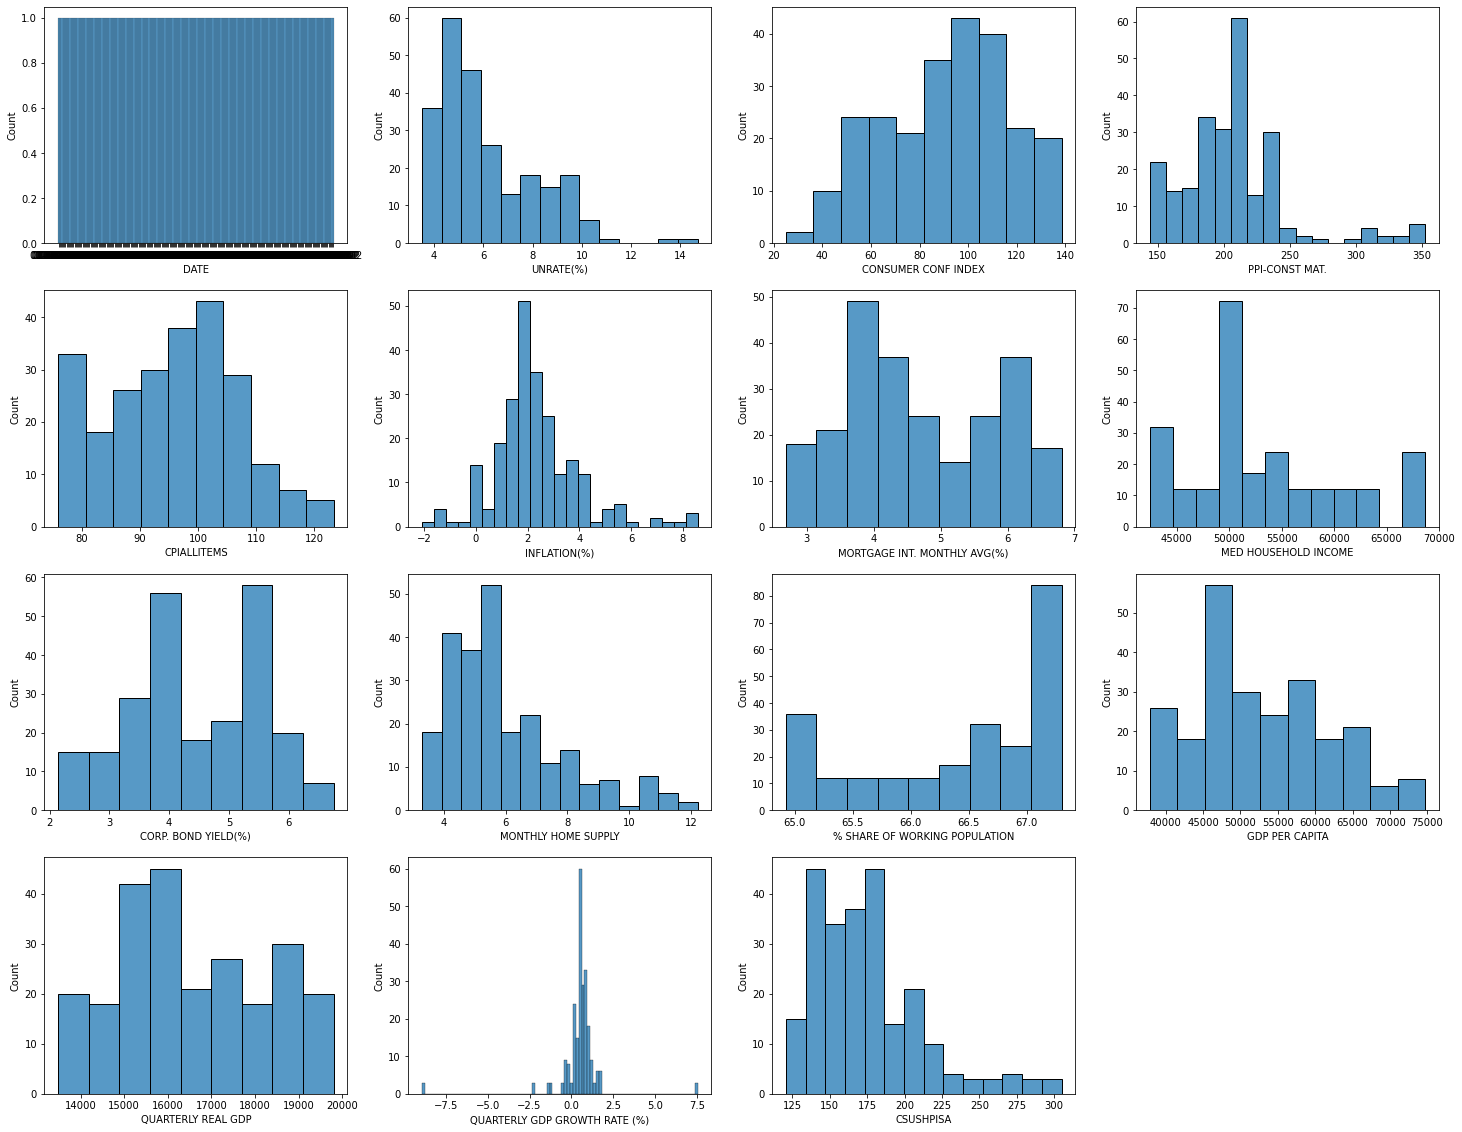

In [7]:
# distribution plots for each feature
plt.figure(figsize=(25,20))
k=1
for i in range(0, len(data.columns)):
    plt.subplot(4,4,k)
    sns.histplot(data[data.columns[i]])
    k+=1

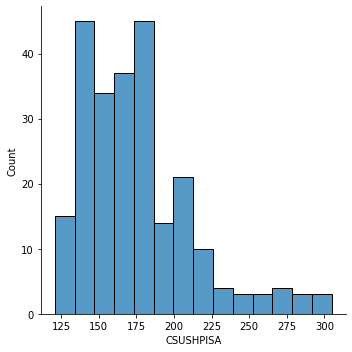

In [8]:
sns.displot(data['CSUSHPISA'])

Some interesting distributions amongst the independent and dependent variable/s, centering and scaling later on should remove problematic distribution.

### Correlation amongst predictors

Lets consider the correlation heatmap below...

<AxesSubplot:>

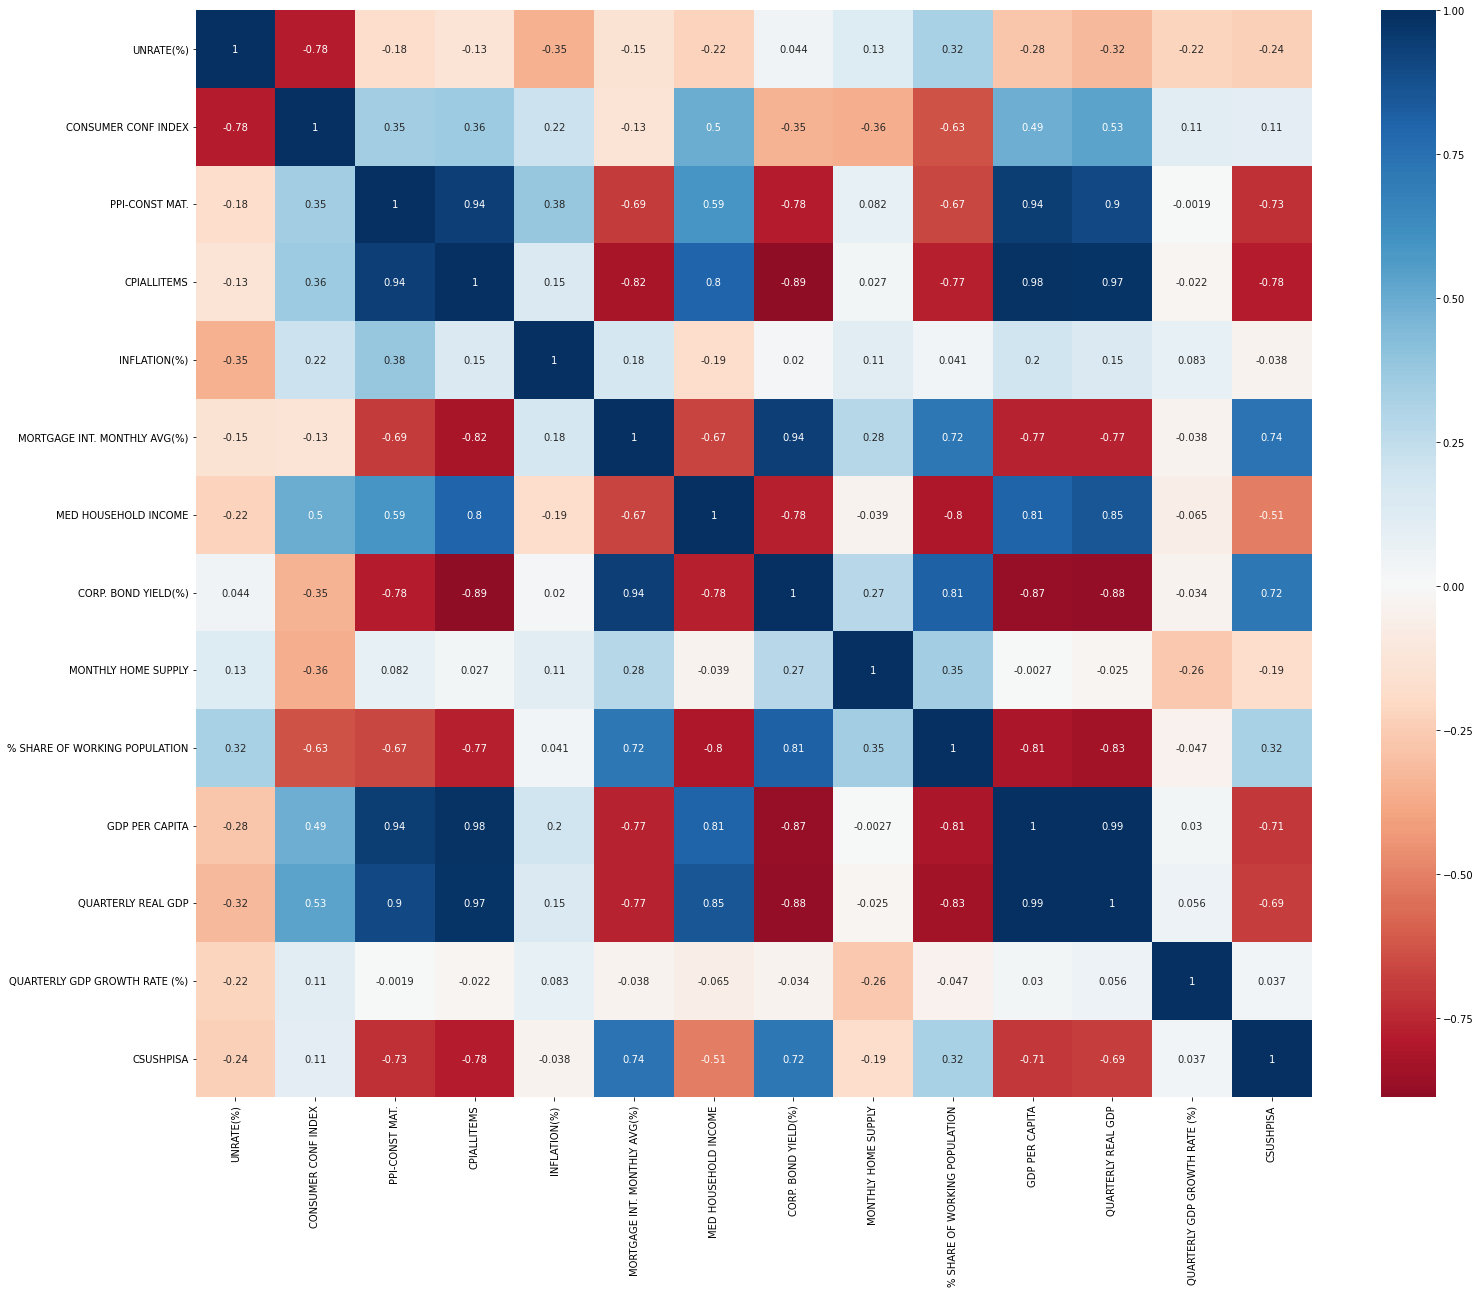

In [9]:
plt.figure(figsize=(25,20))
sns.heatmap(data.corr(),cmap='RdBu', center=0, annot=True)

Its very clear that there is some fairly strong correlation across the board for a handful of the predictors in the dataset, it should be noted that lasso regressions will very consistently push any correlated variables coefficients to 0 leaving only 1 left in the model. This should ultimately be considered when designing these models and how one might hesitate draw any inference if any from lasso/ridge regression models. Ridge will do virtually the same thing however the coefficients are never actually reaching 0 exactly.

### Lets continue adjusting slightly

In [10]:
# lets create a year column and then drop the date column itself

data['DATE']=pd.to_datetime(data['DATE'], dayfirst=True)
data['YEAR']=data['DATE'].dt.year

In [11]:
data.head()

,DATE,UNRATE(%),CONSUMER CONF INDEX,PPI-CONST MAT.,CPIALLITEMS,INFLATION(%),MORTGAGE INT. MONTHLY AVG(%),MED HOUSEHOLD INCOME,CORP. BOND YIELD(%),MONTHLY HOME SUPPLY,% SHARE OF WORKING POPULATION,GDP PER CAPITA,QUARTERLY REAL GDP,QUARTERLY GDP GROWTH RATE (%),CSUSHPISA,YEAR
0,2022-05-01,3.6,106.4,352.857,123.322800,8.581511,5.2300,53273.982143,4.13,8.4,66.410104,74737,19699.465,-0.144227,120.724,2022
1,2022-04-01,3.6,107.3,343.730,121.978170,8.258629,4.9825,53273.982143,3.76,8.4,66.410104,74737,19699.465,-0.144227,121.813,2022
2,2022-03-01,3.6,107.2,345.852,121.301004,8.542456,4.1720,53273.982143,3.43,7.0,66.410104,73289,19727.918,-0.395692,122.888,2022
3,2022-02-01,3.8,110.5,343.583,119.702806,7.871064,3.7625,53273.982143,3.25,6.0,66.410104,73289,19727.918,-0.395692,123.831,2022
4,2022-01-01,4.0,113.8,345.742,118.619339,7.479872,3.4450,53273.982143,2.93,5.7,66.410104,73289,19727.918,-0.395692,124.780,2022


In [12]:
data=data.drop(labels='DATE', axis=1)

### Importance of scaling when using lasso or ridge methods

scaling before performing a ridge or a lasso regression is absolutely necessary, unscaled data in general will be liable to produce large variability in the coefficients which will significantly affect the cost functions ability to appropriately weigh the importance of each feature as the cost itself is based on the coefficients magnitude so to speak. Standardization ensures that the coefficients as a whole are all sized relative to each other.

In [13]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=3)

In [14]:
scaler = StandardScaler()
data_train=scaler.fit_transform(data_train)
data_test=scaler.transform(data_test)

In [15]:
data_train=pd.DataFrame(data_train, columns=data.columns)
data_test=pd.DataFrame(data_test, columns=data.columns)

In [16]:
xtrain=data_train.drop(labels='CSUSHPISA', axis=1)
xtest=data_test.drop(labels='CSUSHPISA', axis=1)

In [17]:
ytrain=data_train['CSUSHPISA']
ytest=data_test['CSUSHPISA']

### Building the model

In [18]:
lass = Lasso(alpha=0.05)

In [19]:
lass.fit(xtrain, ytrain)

Lasso(alpha=0.05)

In [20]:
lass.coef_

array([-0.01872428,  0.10335007, -0.        , -0.78095852,  0.        ,
        0.24774046, -0.        ,  0.16734822, -0.02733438, -0.45708195,
       -0.        , -0.        , -0.        , -0.        ])

In [21]:
lass.score(xtest, ytest)

0.8845528772467843

In [22]:
lass2=Lasso(alpha=0.03)
lass2.fit(xtrain, ytrain)

Lasso(alpha=0.03)

In [23]:
lass2.coef_

array([-0.03503762,  0.07345766, -0.        , -0.76153599,  0.0051579 ,
        0.26379275, -0.        ,  0.232474  , -0.0293656 , -0.59909928,
       -0.        , -0.07100662, -0.        , -0.        ])

In [24]:
lass2.score(xtest, ytest)

0.8938324527562669

Lasso has clearly thinned the herd of features that will be included in the model, the question remains how exactly might we choose the best value for lambda to find a balance in the bias-variance tradeoff? We have fit 2 models the second of which has a higher r2 score however notice that the hyperparameter lambda in the second model was 0.03 as opposed to 0.05 meaning we have reduced the impact of the L1 regularization.

## Cross validation and GridSearch

The main idea and really the simplest method will be selecting a range of values with appropriate spacing in between them and run the same algorithm above then cross validate the r2 scores to find the best model which predicts well on the test set.

In [25]:
lasscv=Lasso(tol=1e-2)

In [26]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
alphas=np.linspace(0.005,0.01,20)

In [27]:
parameters={'alpha':alphas}

In [28]:
lassgrid = GridSearchCV(
    lasscv, parameters, scoring='r2',
    cv=cv, n_jobs=-1,
    return_train_score=True)

In [29]:
lassgrid.fit(xtrain, ytrain)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Lasso(tol=0.01), n_jobs=-1,
             param_grid={'alpha': array([0.005     , 0.00526316, 0.00552632, 0.00578947, 0.00605263,
       0.00631579, 0.00657895, 0.00684211, 0.00710526, 0.00736842,
       0.00763158, 0.00789474, 0.00815789, 0.00842105, 0.00868421,
       0.00894737, 0.00921053, 0.00947368, 0.00973684, 0.01      ])},
             return_train_score=True, scoring='r2')

In [30]:
print(lassgrid.best_params_)
print(lassgrid.best_score_)

{'alpha': 0.008421052631578947}
0.895121264663231


In [31]:
lassgrid.cv_results_['param_alpha']

masked_array(data=[0.005, 0.005263157894736842, 0.005526315789473685,
                   0.005789473684210527, 0.0060526315789473685,
                   0.00631578947368421, 0.006578947368421052,
                   0.006842105263157895, 0.007105263157894737,
                   0.007368421052631579, 0.0076315789473684215,
                   0.007894736842105263, 0.008157894736842105,
                   0.008421052631578947, 0.008684210526315789,
                   0.008947368421052631, 0.009210526315789475,
                   0.009473684210526315, 0.009736842105263158, 0.01],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtype=object)

In [32]:
lassgrid.cv_results_['mean_train_score']

array([0.91888996, 0.91879324, 0.9185658 , 0.91823357, 0.9180616 ,
       0.91800484, 0.91793781, 0.91783794, 0.91777026, 0.9176962 ,
       0.91763206, 0.91746274, 0.91752919, 0.91739631, 0.91711036,
       0.91719399, 0.91704173, 0.91694089, 0.91688214, 0.91673474])

In [33]:
def plot_grid_search_test_train(gs_results, param_1_name, train_score, test_score):
    alphalist1=[]
    for i in range(0, len(gs_results[param_1_name])):
        alphalist1.append(gs_results[param_1_name][i])
    return(sns.lineplot(x=alphalist1, y=gs_results[test_score], label='Test Score'), 
           sns.lineplot(x=alphalist1, y=gs_results[train_score], label='Train Score'))

In [34]:
def plot_grid_search_test(gs_results, param_1_name, test_score):
    alphalist2=[]
    for i in range(0, len(gs_results[param_1_name])):
        alphalist2.append(gs_results[param_1_name][i])
    return(sns.lineplot(x=alphalist2, y=gs_results[test_score], label='Test Score'))

<AxesSubplot:>

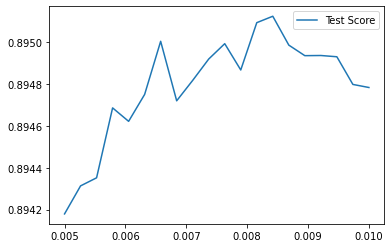

In [35]:
plot_grid_search_test(lassgrid.cv_results_, 'param_alpha', 'mean_test_score')

(<AxesSubplot:>, <AxesSubplot:>)

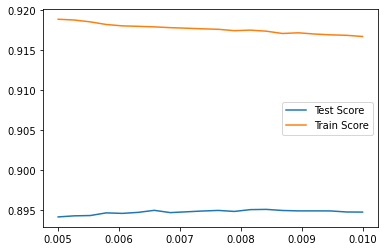

In [36]:
plot_grid_search_test_train(lassgrid.cv_results_, 'param_alpha', 'mean_train_score', 'mean_test_score')

Sklearn also provides a built in package for lasso specifically called LassoCV which is performing roughly the same process as the gridsearchcv and should provide similar if not identical results.

In [37]:
lasso = LassoCV(alphas=alphas, cv=cv, n_jobs=-1)
lasso.fit(xtrain, ytrain)
print(lasso.alpha_)

0.007894736842105263


In [38]:
# We still have some data set aside in the form of xtest and ytest, we can use it as a validation set.
# We can see the score is nearly identical to the best mean test score.

lasso.score(xtest, ytest)

0.89785110671361

### Ridge
The process for ridge regression is exactly the same

In [39]:
ridgereg = Ridge()

In [40]:
ridgegrid = GridSearchCV(
    ridgereg, param_grid=parameters,
    scoring='r2', n_jobs=-1,
    cv=cv, return_train_score=True)

In [41]:
ridgegrid.fit(xtrain, ytrain)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0.005     , 0.00526316, 0.00552632, 0.00578947, 0.00605263,
       0.00631579, 0.00657895, 0.00684211, 0.00710526, 0.00736842,
       0.00763158, 0.00789474, 0.00815789, 0.00842105, 0.00868421,
       0.00894737, 0.00921053, 0.00947368, 0.00973684, 0.01      ])},
             return_train_score=True, scoring='r2')

In [42]:
ridgegrid.best_params_

{'alpha': 0.01}

In [43]:
ridgegrid.best_score_

0.9103572498247191

In [44]:
ridgegrid.cv_results_['mean_test_score']

array([0.91032655, 0.91032897, 0.91033129, 0.91033351, 0.91033565,
       0.91033769, 0.91033965, 0.91034151, 0.91034329, 0.91034498,
       0.91034658, 0.9103481 , 0.91034953, 0.91035088, 0.91035214,
       0.91035333, 0.91035443, 0.91035545, 0.91035639, 0.91035725])

<AxesSubplot:>

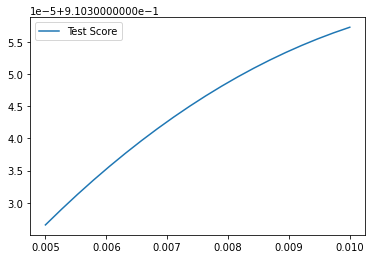

In [45]:
plot_grid_search_test(ridgegrid.cv_results_, 'param_alpha', 'mean_test_score')

(<AxesSubplot:>, <AxesSubplot:>)

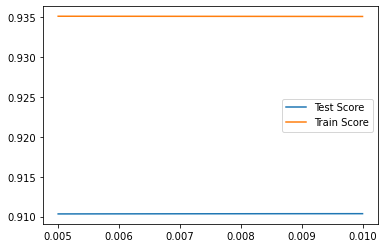

In [46]:
# The scale that both test and train scores exist on are too small to capture the trends in both results simultaneously
# The above graph does show that it may make sense to increase the value of alpha beyond 0.01

plot_grid_search_test_train(ridgegrid.cv_results_, 'param_alpha', 'mean_train_score', 'mean_test_score')

### Results:

Assessing the results of both the gridsearch CV as well as the LassoCV we can see that the mean cross validated test score shown in the graph actually appreciates to a point then decreases! This is a clear indication of the successfulness of using a gridsearch to optimally choose a hyperparamter value for $\lambda$